In [1]:
import json
import umap
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime,timedelta
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
%matplotlib inline
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/opt/anaconda/anaconda3/envs/stickk/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda/anaconda3/envs/stickk/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/anaconda/anaconda3/envs/stickk/lib/python3.11/site-packages/uma

In [2]:
user_index = json.load(open("../data/user_index.json",'r'))
commitment_index = json.load(open("../data/commitment_index.json",'r'))

In [3]:
max_user_id = max([int(i) for i in user_index.keys()])

In [4]:
for k,v in tqdm(user_index.items()):
    user_index[k]['date'] = datetime.strptime(v['date'], '%d %b %Y')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521632/521632 [00:03<00:00, 154630.03it/s]


In [5]:
id_for_1_jan_2023 = 722621
for k,v in tqdm(user_index.items()):
    if int(k)<id_for_1_jan_2023 and v['date'].year == 2023:
        user_index[k]['date'] = None

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521632/521632 [00:00<00:00, 2213049.99it/s]


In [6]:
last_date = user_index['1']['date']
for i in range(1, max_user_id+1):
    if str(i) in user_index.keys():
        if user_index[str(i)]['date'] == None:
            user_index[str(i)]['date'] = last_date
        else:
            last_date = user_index[str(i)]['date']

In [7]:
for k,v in tqdm(commitment_index.items()):
    commitment_index[k]['start_date'] = datetime.strptime(v['start_date'], '%B %d, %Y')
    commitment_index[k]['end_date'] = datetime.strptime(v['end_date'], '%B %d, %Y')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:03<00:00, 80083.48it/s]


In [8]:
for k,v in tqdm(commitment_index.items()):
    if v['start_date'].year < 2007:
        deta = v['end_date'] - v['start_date']
        commitment_index[k]['start_date'] = user_index[str(v['user_id'])]['date']
        commitment_index[k]['end_date'] = commitment_index[k]['start_date'] + deta

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319928/319928 [00:00<00:00, 2805685.68it/s]


Extract data

In [9]:
raw_data = []
for k,v in commitment_index.items():
    raw_data.append(f"{v['title']}. {v['description']}")

In [10]:
len(raw_data)

319928

In [11]:
#  raw_data = raw_data[:1000]

In [12]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [13]:
embeddings = model.encode(raw_data, show_progress_bar=True)

Batches:   0%|          | 0/9998 [00:00<?, ?it/s]

In [14]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

KeyboardInterrupt: 

In [16]:
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

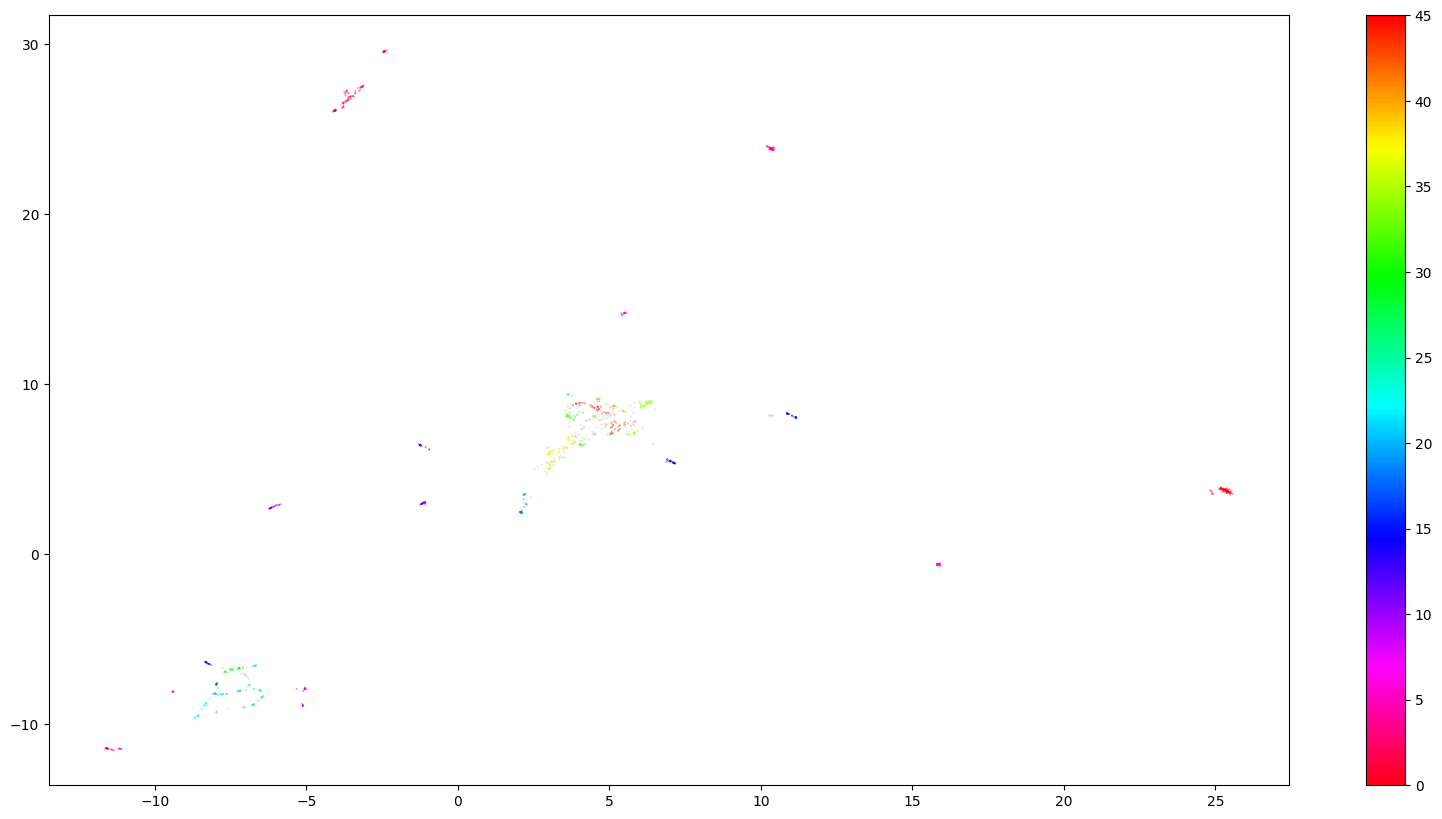

In [20]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

c-TF-IDF

In [22]:
docs_df = pd.DataFrame(raw_data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [25]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [26]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_data))

In [30]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [31]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [32]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,168
3,2,75
1,0,72
5,4,46
7,6,33
35,34,31
39,38,30
14,13,29
4,3,27
12,11,25


In [40]:
for i in [2,0,4,6,34,38]:
    print(i)
    print(top_n_words[i][:10])
    print("-"*50)

2
[('test', 0.7216367555166444), ('testing', 0.14176700371219494), ('new', 0.09838490255720748), ('section', 0.08352646220006665), ('shot', 0.08100971640696855), ('stickk', 0.0709029538207445), ('stakes', 0.06487735550875146), ('08', 0.06264484665004999), ('draft', 0.06075728730522641), ('religion', 0.05073149468099748)]
--------------------------------------------------
0
[('exercise', 0.333185302976463), ('days', 0.31693537010163625), ('regularly', 0.2906961895719054), ('week', 0.10742227617379084), ('running', 0.041593461867919373), ('proper', 0.03368351272857556), ('firefox', 0.03368351272857556), ('place', 0.031485869866200694), ('reporting', 0.02871716729836334), ('items', 0.026893469538898773)]
--------------------------------------------------
4
[('day', 0.43917768560441217), ('exercise', 0.35791958311008687), ('regularly', 0.3170805061397015), ('week', 0.11037960103522992), ('fart', 0.05427605326132918), ('basis', 0.05427605326132918), ('daily', 0.03558551908232245), ('work', 

In [44]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(raw_data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [48]:
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,219
3,2,75
1,0,72
16,15,60
8,7,56
5,4,46
6,5,46
4,3,35
20,19,31
24,23,30


In [52]:
for i in [2,0,15,7,4,5,3,19,23]:
    print(i)
    print(top_n_words[i][:10])
    print("-"*50)

2
[('test', 0.7216367555166444), ('testing', 0.14176700371219494), ('new', 0.09838490255720748), ('section', 0.08352646220006665), ('shot', 0.08100971640696855), ('stickk', 0.0709029538207445), ('stakes', 0.06487735550875146), ('08', 0.06264484665004999), ('draft', 0.06075728730522641), ('religion', 0.05073149468099748)]
--------------------------------------------------
0
[('exercise', 0.333185302976463), ('days', 0.31693537010163625), ('regularly', 0.2906961895719054), ('week', 0.10742227617379084), ('running', 0.041593461867919373), ('proper', 0.03368351272857556), ('firefox', 0.03368351272857556), ('place', 0.031485869866200694), ('reporting', 0.02871716729836334), ('items', 0.026893469538898773)]
--------------------------------------------------
15
[('lose', 0.28245024804099084), ('weight', 0.21630551838940978), ('lbs', 0.21504266553458246), ('15', 0.16320540173125198), ('17', 0.1165338502889862), ('16', 0.10848537747251172), ('12', 0.1072981440816842), ('22', 0.09519731650621378